In [103]:
# CS180 (CS280A): Project 1 starter Python code

# these are just some suggested libraries
# instead of scikit-image you could use matplotlib and opencv to read, write, and display images

import numpy as np
import skimage as sk
import skimage.io as skio
import logging
import matplotlib.pyplot as plt
import skimage.exposure as exposure
import skimage.color as color
import os
import scipy
import cv2
import skimage.transform as transform
from skimage.draw import polygon
import imageio

from IPython.display import Image, display
import glob
import pandas as pd
import dlib
from scipy.ndimage import map_coordinates
from scipy.ndimage import distance_transform_edt


  # load the dlib model
# detector = dlib.get_frontal_face_detector()
# predictor_path = 'shape_predictor_68_face_landmarks.dat'  # Ensure this file is in your working directory
# predictor = dlib.shape_predictor(predictor_path)
# set up logging
# levels are DEBUG, INFO, WARNING, ERROR, CRITICAL
# logging.basicConfig(level=logging.CRITICAL)


In [3]:
OUTPUT_PATH = '../../outputs/'
DATA_PATH = '../../../data/'

def load_image_as_float(imname):
    # concatenate the image name with the path
    imname = DATA_PATH + imname
    im = skio.imread(imname)
    # convert to float (might want to do this later on to save memory)
    im = sk.img_as_float(im)
    return im

def show_image(im, title=None):
    plt.figure()
    plt.imshow(im)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

def export_image(im, imname, path=OUTPUT_PATH):
    # Convert RGBA to RGB if necessary
    if im.shape[-1] == 4:
        im = color.rgba2rgb(im)
    # convert to jpg
    im = sk.img_as_ubyte(im)
    fname = path + imname.split('.')[0] + '.jpg'
    skio.imsave(fname, im)

In [15]:
def show_image_with_points(image, points, title='Image with Points'):
    plt.figure()
    plt.imshow(image)
    plt.scatter(points[:, 0], points[:, 1], c='r', marker='o')
    plt.title(title)
    plt.show()

def show_collection_of_images(images):
    plt.figure()
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

def show_collection_of_images_with_titles(images, titles):
    plt.figure(figsize=(15, 5))  # Adjust figure size for better layout
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(titles[i], wrap=True)  # Enable text wrapping
    plt.tight_layout()  # Adjust subplot layout
    plt.show()

In [5]:
# crop image from the bottom, to match target image ratio
def crop_image(im, target_im):
    # get the target ratio
    target_ratio = target_im.shape[0] / target_im.shape[1]
    # print("target_ratio: ", target_ratio)
    # get the aspect ratio of the image
    im_ratio = im.shape[0] / im.shape[1]
    # print("im_ratio: ", im_ratio)
    # crop the image to match the target ratio
    if im_ratio > target_ratio:
        # crop the image from the bottom
        im = im[:int(im.shape[1] * target_ratio), :]
    else:
        # crop the image from the right and left equally
        # Calculate the width to crop from each side
        # w1 - (h1*w2)/h2 = x
        crop_width = int((im.shape[1] - ((im.shape[0]*target_im.shape[1]) / target_im.shape[0])) / 2)
        # Crop the image from the right and left equally
        im = im[:, crop_width:-crop_width]

    # print("new ratio: ", im.shape[0] / im.shape[1])
    return im

In [6]:
def match_dimensions(changingImage, targetImage):
    # resize the changing image to match the target image dimensions
    changingImage = transform.resize(changingImage, targetImage.shape[:2])
    return changingImage

def addWhiteSpace(image, percent, direction):
    # add white space by the percent in the specified direction
    # direction is 'top', 'bottom', 'left', or 'right'
    # percent is a float between 0 and 1
    # add white space to the image
    if direction == 'top':
        image = np.pad(image, ((int(image.shape[0] * percent), 0), (0, 0), (0, 0)))
    elif direction == 'bottom':
        image = np.pad(image, ((0, int(image.shape[0] * percent)), (0, 0), (0, 0)))
    elif direction == 'left':
        image = np.pad(image, ((0, 0), (int(image.shape[1] * percent), 0), (0, 0)))
    elif direction == 'right':
        image = np.pad(image, ((0, 0), (0, int(image.shape[1] * percent)), (0, 0)))
    return image

def generate_canvas(image, padding=100):
    canvas = np.ones((image.shape[0] + padding, image.shape[1] + padding, 3))
    return canvas

In [85]:
# import json
import json

def import_correspondences(im1_name, im2_name, im1, im2):
    # take off the .jpeg if its there
    im1_name = im1_name.split('.')[0]
    im2_name = im2_name.split('.')[0]
    # load the json file
    with open(DATA_PATH + f'{im1_name}_{im2_name}.json', 'r') as f:
        correspondences = json.load(f)

    # get the points
    im1Points = correspondences['im1Points']
    im2Points = correspondences['im2Points']
    print("len of im1Points: ", len(im1Points))

    # add points to the corner of each image
    # im1Points.append((0, 0))
    # im2Points.append((0, 0))
    # im1Points.append((0, im1.shape[0]-1))
    # im2Points.append((0, im2.shape[0]-1))
    # im1Points.append((im1.shape[1]-1, 0))
    # im2Points.append((im2.shape[1]-1, 0))
    # im1Points.append((im1.shape[1]-1, im1.shape[0]-1))
    # im2Points.append((im2.shape[1]-1, im2.shape[0]-1))
    # calculate midway points without using for loops
    im1Points = np.array(im1Points)
    im2Points = np.array(im2Points) 

    return im1Points, im2Points

# Image Rectification on frames

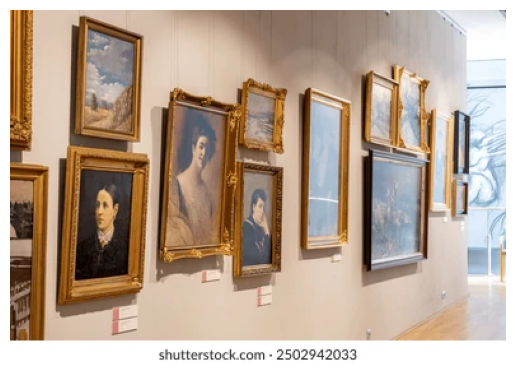

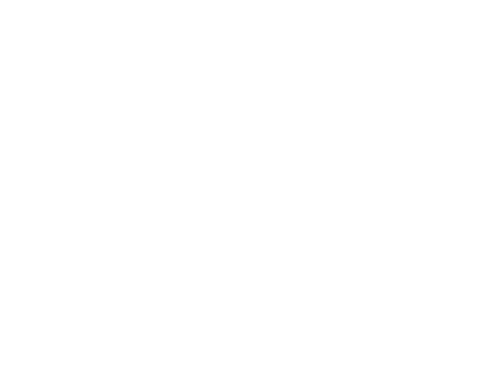

/var/folders/zq/lptg8bhj1_7csl86sd1517pc0000gn/T/ipykernel_28219/448437520.py:27: UserWarning: ../../../data/canvas.jpg is a low contrast image
  skio.imsave(fname, im)


In [8]:
# import image
gallery = load_image_as_float('gallery.webp')
show_image(gallery)

# generate canvas with matching dimensions
canvas = generate_canvas(gallery)
show_image(canvas)
export_image(canvas, 'canvas', DATA_PATH)

In [9]:
%matplotlib inline

gallery_points:  [[ 60.89354839   8.66129032]
 [100.14516129  24.26129032]
 [ 98.13225806  99.24193548]
 [ 54.85483871  96.22258065]]


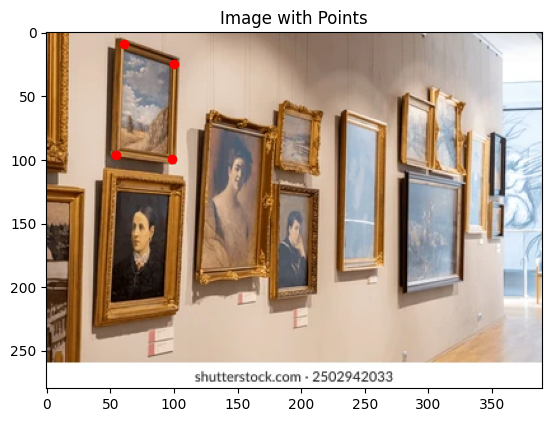

In [10]:
# define corrspondences, create points for an image
# use ginput to get points from user
def select_points(image, n):
    """
    Allow the user to select n points on the given image.
    
    Args:
    image (numpy.ndarray): The image on which to select points.
    n (int): The number of points to select.
    
    Returns:
    numpy.ndarray: A nx2 array of selected points.
    """
    # set the ginput to be not in inline
    %matplotlib qt

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.title(f"Select {n} points")

    
    # Let the user select n points
    points = plt.ginput(n, timeout=-1)
    
    # Close the plot
    plt.close()
    
    # Convert the list of tuples to an nx2 numpy array
    points_array = np.array(points)
    
    # set back to inline
    %matplotlib inline
    return points_array


gallery_points = select_points(gallery, 4)
print("gallery_points: ", gallery_points)
show_image_with_points(gallery, gallery_points)


In [136]:
# generate canvas
def generate_canvas(image, padding=100):
    canvas = np.zeros((image.shape[0] + padding, image.shape[1] + padding, 3))
    return canvas

def generate_canvas_from_points(points, padding=0):
    # Calculate the bounding box
    min_x = np.min(points[:, 0])
    min_y = np.min(points[:, 1])
    max_x = np.max(points[:, 0])
    max_y = np.max(points[:, 1])

    # generate corners
    corners = np.array([[min_x, min_y], [min_x, max_y], [max_x, min_y], [max_x, max_y]])
    # Calculate the origin offset
    origin_offset = (min_x - padding, min_y - padding)
    
    # Calculate canvas dimensions
    canvas_width = int(max_x - min_x + 2 * padding)
    canvas_height = int(max_y - min_y + 2 * padding)
    
    # Create the canvas
    canvas = np.zeros((canvas_height, canvas_width, 3))
    
    return canvas, origin_offset, corners

def generate_rectangle_points(length, width):
    points = np.array([[0, 0], [0, length], [width, 0], [width, length]])
    return points



# Recover Homographies

In [133]:
gallery_points, canvas_points = import_correspondences('gallery', 'canvas', gallery, canvas)
print("gallery_points shape: ", gallery_points.shape)
print("canvas_points shape: ", canvas_points.shape)
print("gallery_points: ", gallery_points)
print("canvas_points: ", canvas_points)

len of im1Points:  4
gallery_points shape:  (4, 2)
canvas_points shape:  (4, 2)
gallery_points:  [[ 55  94]
 [100 101]
 [104  25]
 [ 58   9]]
canvas_points:  [[ 67 142]
 [179 142]
 [179  33]
 [ 68  33]]


h:  [ 1.77951751e+00  2.42261770e-02 -4.29530803e+01 -4.36627362e-01
  1.06548065e+00  4.50841792e+01 -1.83230730e-03 -4.84329065e-04]
h shape:  (8,)
new_points:  [[ 67 142]
 [179 141]
 [178  32]
 [ 68  32]]


/var/folders/zq/lptg8bhj1_7csl86sd1517pc0000gn/T/ipykernel_28219/591342924.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  h = np.linalg.lstsq(A, B)[0]


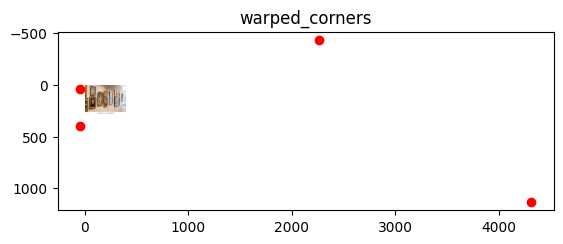

warped_corners:  [[ -42.95308033   45.08417924]
 [ -41.84893135  395.84262835]
 [2260.46606544 -434.36547708]
 [4313.07213424 1134.1220393 ]]
oldPolyY shape:  (109200,)
oldPolyX shape:  (109200,)
newPolyY shape:  (4896390,)
newPolyX shape:  (4896390,)


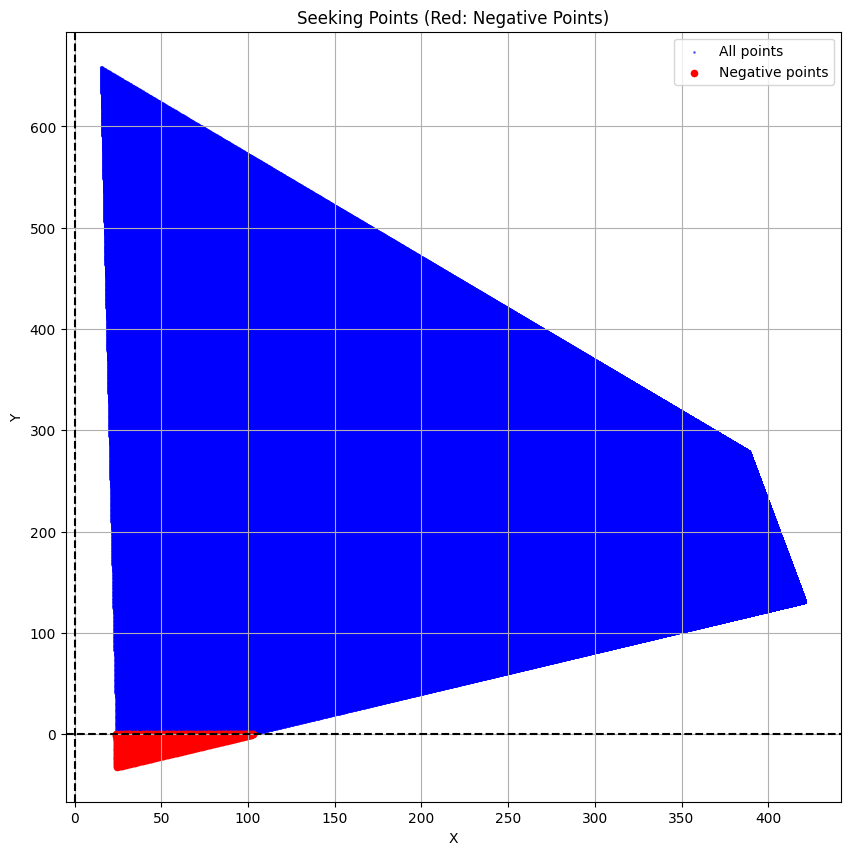

Total points: 4896390
Negative points: 3243
points shape:  (109200, 2)
values shape:  (109200, 3)
seekingPoints shape:  (4896390, 2)
warped_im shape:  (1568, 4356, 3)
newColors shape:  (4896390, 3)


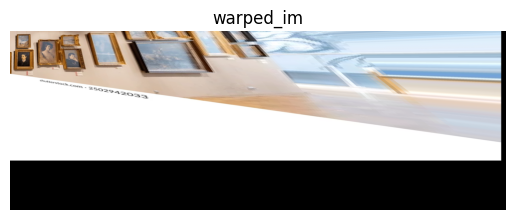

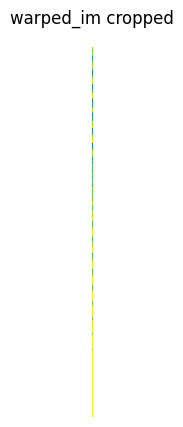

warped_im shape:  (4896390, 3)


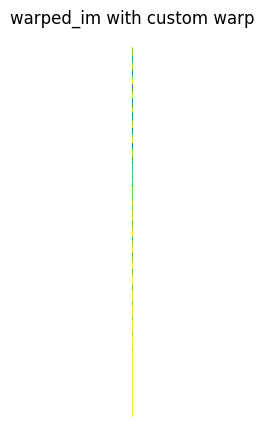

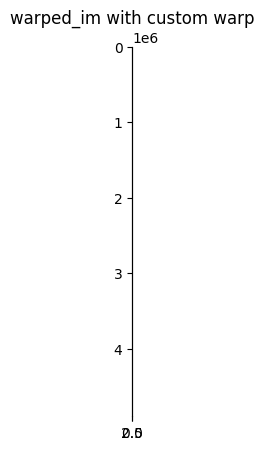

In [159]:
def computeH(im1Points, im2Points):
    # points are n by 2
    n = im1Points.shape[0]
    # Ah = B
    # compute the homography matrix given n points
    A = []
    B = []
    # fill in A and B
    for i in range(n):
        x1, y1 = im1Points[i, 0], im1Points[i, 1]
        x2, y2 = im2Points[i, 0], im2Points[i, 1]
        A.append([x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1])
        A.append([0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1])
        B.append(x2)
        B.append(y2)
        
    A = np.array(A)
    B = np.array(B)

    # solve for h
    h = np.linalg.lstsq(A, B)[0]
    print("h: ", h)
    print("h shape: ", h.shape)
    # reshape h
    h = np.append(h, 1)
    h = h.reshape((3, 3))
    return h

def warpImage(im, H):
    # warp the image using the homography matrix
    # warped_im = cv2.warpPerspective(im, H, (im.shape[1], im.shape[0]))
    # first warp the corners of the image to get the dimensions of the warped image
    corners = np.array([[0, 0], [0, im.shape[0]-1], [im.shape[1]-1, 0], [im.shape[1]-1, im.shape[0]-1]])
    
    print("corners: ", corners)
    homogeneous_corners = np.hstack((corners, np.ones((corners.shape[0], 1))))
    warped_corners = H @ homogeneous_corners.T
    # convert back to homogeneous coordinates
    warped_corners = warped_corners / warped_corners[2, :] # normalize
    warped_corners = warped_corners[:2, :].T # convert back to cartesian coordinates
    # display the warped corners
    show_image_with_points(im, warped_corners)
    # get the dimensions of the warped image
    warped_height = int(np.max(warped_corners[:, 1]) - np.min(warped_corners[:, 1]))
    warped_width = int(np.max(warped_corners[:, 0]) - np.min(warped_corners[:, 0]))
    print("warped_height: ", warped_height)
    print("warped_width: ", warped_width)
    # warp the image
    warped_im = cv2.warpPerspective(im, H, (warped_width, warped_height))
    return warped_im

def other_warp(im, H):
    if im.dtype != np.float32:
        im = im.astype(np.float32) / 255.0
    
    h, w, c = im.shape
    y, x = np.mgrid[:h, :w]
    coords = np.stack((x, y, np.ones_like(x)), axis=-1)
    
    H_inv = np.linalg.inv(H)
    transformed_coords = coords @ H_inv.T
    transformed_coords = transformed_coords[..., :2] / transformed_coords[..., 2:3]
    
    imwarped = np.zeros_like(im)
    
    for i in range(c):
        imwarped[..., i] = map_coordinates(im[..., i], transformed_coords[..., :2].transpose(2, 0, 1), order=1, mode='nearest')
    
    if im.dtype == np.uint8:
        imwarped = (imwarped * 255).astype(np.uint8)
    
    return imwarped

def custom_warp(im, H):
    corners = np.array([[0, 0], [0, im.shape[0]-1], [im.shape[1]-1, 0], [im.shape[1]-1, im.shape[0]-1]])
    homogeneous_corners = np.hstack((corners, np.ones((corners.shape[0], 1))))
    warped_corners = H @ homogeneous_corners.T

    warped_corners = warped_corners / warped_corners[2, :] # normalize
    warped_corners = warped_corners[:2, :].T # convert back to cartesian coordinates

    show_image_with_points(im, warped_corners, title='warped_corners')
    
    # generate a canvas that contains the warped corners
    canvas, origin_offset, bbox_corners = generate_canvas_from_points(warped_corners)

    # get the corners of the canvas
    new_corners = np.array([[0, 0], [0, canvas.shape[0]-1], [canvas.shape[1]-1, 0], [canvas.shape[1]-1, canvas.shape[0]-1]])
    # show_image_with_points(canvas, new_corners, title='new_corners')

    # offset everything by the origin offset
    print("warped_corners: ", warped_corners)
    # show_image_with_points(canvas, warped_corners, title='warped_corners_offset')

    # warp the image using inverse warping
    H_inv = np.linalg.inv(H)

    # for i in range(corners.shape[0]):
    #     plt.scatter(corners[i, 0], corners[i, 1], c=colors[i], marker='o')
    # plt.show()

    # for i in range(warped_corners.shape[0]):
    #     plt.scatter(warped_corners[i, 0], warped_corners[i, 1], c=colors[i], marker='o')
    # plt.show()
    # reorder the points for the polygon
    # switch the 3rd and 4th points
    corners[[2, 3]] = corners[[3, 2]]
    warped_corners[[2, 3]] = warped_corners[[3, 2]]
    bbox_corners[[2, 3]] = bbox_corners[[3, 2]]
    new_corners[[2, 3]] = new_corners[[3, 2]]

    # Create a meshgrid of coordinates for the canvas
    row1_values = [tuple[1] for tuple in corners]
    col1_values = [tuple[0] for tuple in corners]
    row2_values = [tuple[1] for tuple in bbox_corners]
    col2_values = [tuple[0] for tuple in bbox_corners]

    oldPolyY, oldPolyX = polygon(row1_values, col1_values)
    newPolyY, newPolyX = polygon(row2_values, col2_values)
    print("oldPolyY shape: ", oldPolyY.shape)
    print("oldPolyX shape: ", oldPolyX.shape)
    print("newPolyY shape: ", newPolyY.shape)
    print("newPolyX shape: ", newPolyX.shape)

    # Create homogeneous coordinates
    stackedPixelMatrix = np.vstack((newPolyX, newPolyY, np.ones(len(newPolyX))))

    # Apply inverse homography to all points at once
    colorSeekingPixels = H_inv @ stackedPixelMatrix
    
    # Normalize the coordinates
    colorSeekingPixels = colorSeekingPixels / colorSeekingPixels[2, :] # normalize
    colorSeekingPixels = colorSeekingPixels[:2, :].T # convert back to cartesian coordinates
    
    warped_im = np.zeros_like(canvas)
    # Interpolate values for valid coordinates
    points = np.vstack((oldPolyX, oldPolyY)).T
    values = im[oldPolyY, oldPolyX]
    seekingPoints = colorSeekingPixels

    # Plot the seeking points, focusing on any negative points
    plt.figure(figsize=(10, 10))
    plt.scatter(seekingPoints[:, 0], seekingPoints[:, 1], c='blue', alpha=0.5, s=1, label='All points')
    
    # Find negative points
    negative_points = seekingPoints[(seekingPoints[:, 0] < 0) | (seekingPoints[:, 1] < 0)]
    
    if negative_points.size > 0:
        plt.scatter(negative_points[:, 0], negative_points[:, 1], c='red', s=20, label='Negative points')
    
    # plt.axhline(y=0, color='k', linestyle='--')
    # plt.axvline(x=0, color='k', linestyle='--')
    # plt.xlabel('X')
    # plt.ylabel('Y')
    # plt.title('Seeking Points (Red: Negative Points)')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    print(f"Total points: {seekingPoints.shape[0]}")
    print(f"Negative points: {negative_points.shape[0]}")

    # print("offsetSeekingPoints: ", offsetSeekingPoints[0])

    print("points shape: ", points.shape)
    print("values shape: ", values.shape)
    print("seekingPoints shape: ", seekingPoints.shape)
    print("warped_im shape: ", warped_im.shape)


    # points of data, data itself, points to interpolate to, method
    newColors = scipy.interpolate.griddata(
        points,
        values,
        seekingPoints,
        method='nearest'
    )
    print("newColors shape: ", newColors.shape)
    warped_im[newPolyY, newPolyX] = newColors
    show_image(warped_im, "warped_im")
    # crop image to values that are not zero
    warped_im = warped_im[~np.all(warped_im == 0, axis=-1)]
    show_image(warped_im, "warped_im cropped")
    return warped_im


def applyHonOnepoint(point, H):
    # apply the homography matrix to the point
    new_point = np.dot(H, np.array([point[0], point[1], 1]))
    # normalize the point
    new_point = new_point / new_point[2]
    return new_point[:2]  # Return only x and y coordinates


def applyH(gallery_points, H):
    # apply the homography matrix to the points, simply output the new points
    # points are n by 2
    new_points = np.zeros_like(gallery_points)
    for i in range(gallery_points.shape[0]):
        new_points[i] = applyHonOnepoint(gallery_points[i], H)
    return new_points
# display each point as a different color
colors = ['r', 'y', 'g', 'b']
# print("gallery_points: ", gallery_points)
# print("canvas_points: ", canvas_points)
# print("gallery_points shape: ", gallery_points.shape)
# print("canvas_points shape: ", canvas_points.shape)
# compute the homography matrix
H = computeH(gallery_points, canvas_points)
new_points = applyH(gallery_points, H)
print("new_points: ", new_points)
# show_image_with_points(canvas, new_points, title='new_points')


# # # warp the image
# warped_im = warpImage(gallery, H)
# warped_im = np.roll(warped_im, 100, axis=0)
# print("warped_im shape: ", warped_im.shape)
# show_image(warped_im, "warped_im with cv2")

# warp the image with custom warp
warped_im = custom_warp(gallery, H)
# move the warped_im down 100 pixels
print("warped_im shape: ", warped_im.shape)
show_image(warped_im, "warped_im with custom warp")
show_image_with_points(warped_im, warped_im, title='warped_im with custom warp')


In [172]:
def get_center_rectangle_points(image_width, image_height, padding=100):
    # Calculate the coordinates of the rectangle
    left = padding
    right = image_width - padding
    top = padding
    bottom = image_height - padding
    
    # Points in clockwise order
    points = np.array([[left, top], [right, top], [right, bottom], [left, bottom]])
    return points

In [180]:
def rectify_image(imagePath):
    image = load_image_as_float(imagePath)
    im1points, im2points = import_correspondences(imagePath, f'{imagePath.split(".")[0]}_canvas.jpg', image, canvas)
    
    # im1points = im1points[:4]
    # im2points = im2points[:4]
    # im2points = get_center_rectangle_points(image.shape[1], image.shape[0], padding=300)
    # show image with points
    show_image_with_points(image, im1points, title='im1points')
    show_image_with_points(canvas, im2points, title='im2points')
    
    # compute the homography matrix
    H = computeH(im1points, im2points)
    # warp the image
    warped_im = warpImage(image, H)
    return warped_im

In [170]:

# generate a canvas for prez screen
def generate_canvas_for_prez(imagePath):
    image = load_image_as_float(imagePath)
    canvas = generate_canvas(image)
    export_image(canvas, f'/{imagePath.split(".")[0]}_canvas.jpg', DATA_PATH)
    return canvas

canvas = generate_canvas_for_prez('pres.jpeg')

/var/folders/zq/lptg8bhj1_7csl86sd1517pc0000gn/T/ipykernel_28219/448437520.py:27: UserWarning: ../../../data//pres_canvas.jpg is a low contrast image
  skio.imsave(fname, im)


len of im1Points:  9


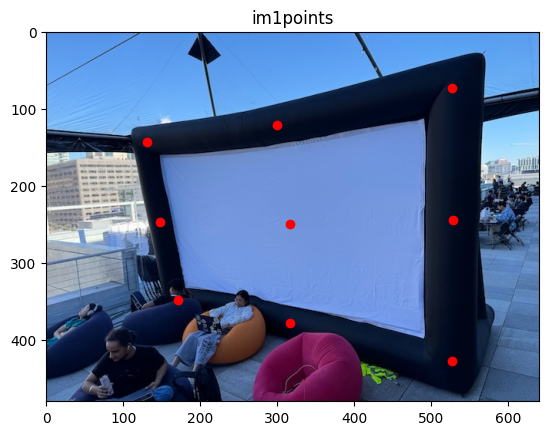

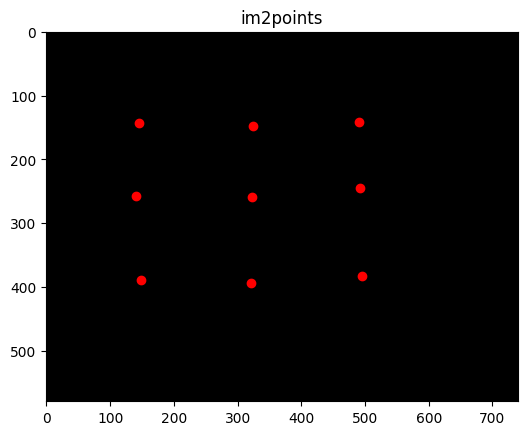

h:  [ 1.63746854e+00 -4.12459392e-01 -4.36755467e+00  3.32444312e-01
  8.65025448e-01 -4.87139102e+00  1.46012823e-03 -9.21295230e-04]
h shape:  (8,)
corners:  [[  0   0]
 [  0 479]
 [639   0]
 [639 479]]


/var/folders/zq/lptg8bhj1_7csl86sd1517pc0000gn/T/ipykernel_28219/591342924.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  h = np.linalg.lstsq(A, B)[0]


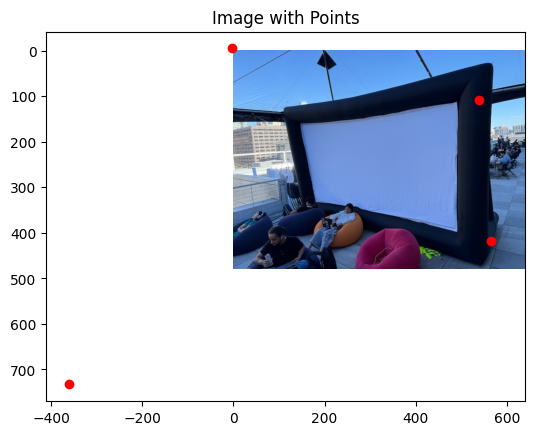

warped_height:  737
warped_width:  927


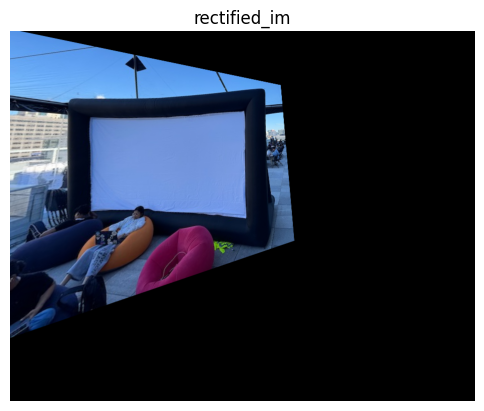

In [181]:
rectified_im = rectify_image('pres.jpeg')
show_image(rectified_im, "rectified_im")


In [182]:
# generate a canvas for tiles
generate_canvas_for_prez('tiles.jpeg')

/var/folders/zq/lptg8bhj1_7csl86sd1517pc0000gn/T/ipykernel_28219/448437520.py:27: UserWarning: ../../../data//tiles_canvas.jpg is a low contrast image
  skio.imsave(fname, im)


array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

len of im1Points:  10


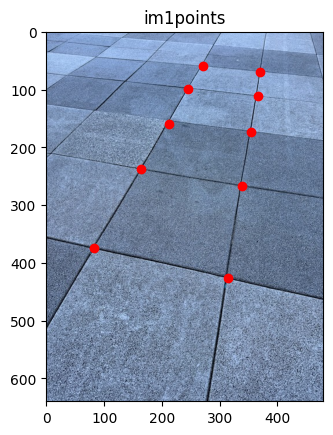

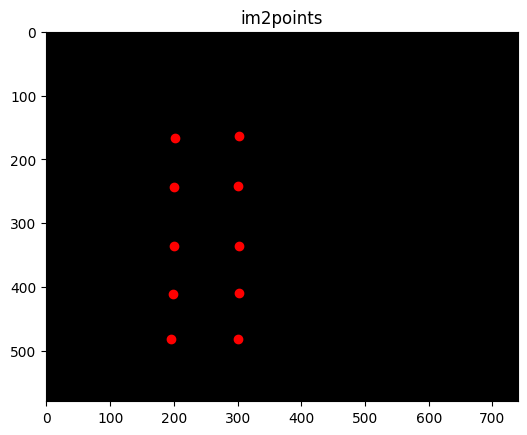

h:  [ 1.12982834e+00  1.81950607e+00 -1.78028257e+02 -4.33402731e-01
  3.69877965e+00  9.79374403e+01 -4.82219577e-04  5.46697945e-03]
h shape:  (8,)
corners:  [[  0   0]
 [  0 639]
 [479   0]
 [479 639]]


/var/folders/zq/lptg8bhj1_7csl86sd1517pc0000gn/T/ipykernel_28219/591342924.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  h = np.linalg.lstsq(A, B)[0]


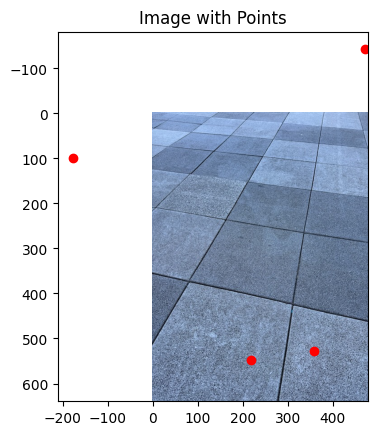

warped_height:  690
warped_width:  650


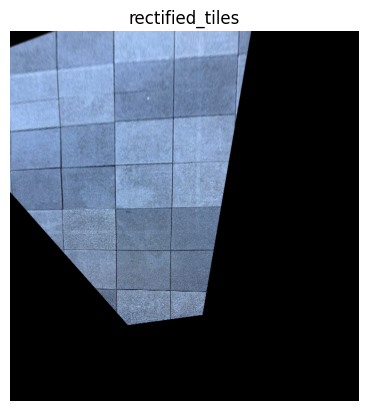

In [183]:
rectified_tiles = rectify_image('tiles.jpeg')
show_image(rectified_tiles, "rectified_tiles")


# Warping images to create a homography

len of im1Points:  24


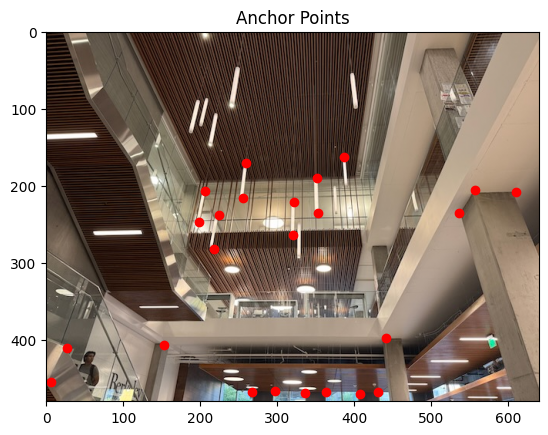

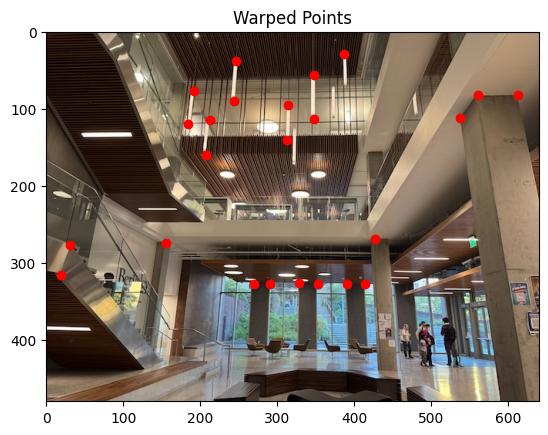

h:  [ 8.55726806e-01 -1.82036656e-01  4.56156128e+01 -2.73069479e-02
  7.21562228e-01  1.44836140e+02 -6.62157446e-05 -5.63539792e-04]
h shape:  (8,)
corners:  [[  0   0]
 [  0 479]
 [639   0]
 [639 479]]


/var/folders/zq/lptg8bhj1_7csl86sd1517pc0000gn/T/ipykernel_28219/2846865240.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  h = np.linalg.lstsq(A, B)[0]


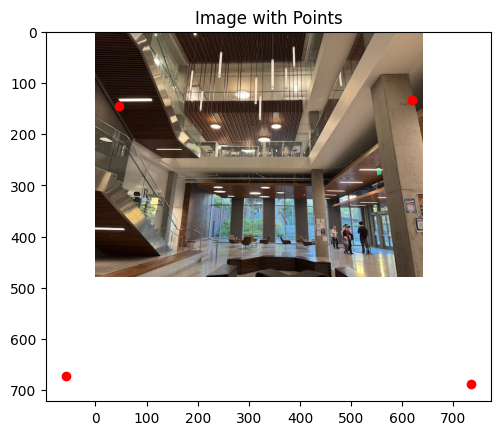

warped_height:  554
warped_width:  791


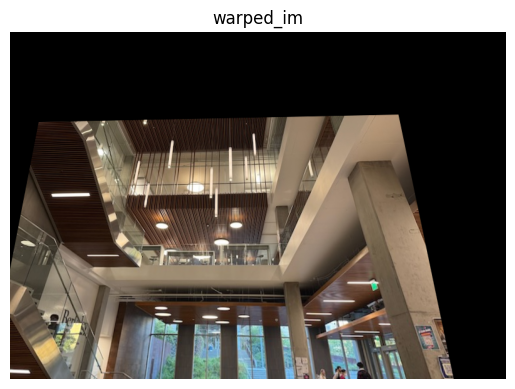

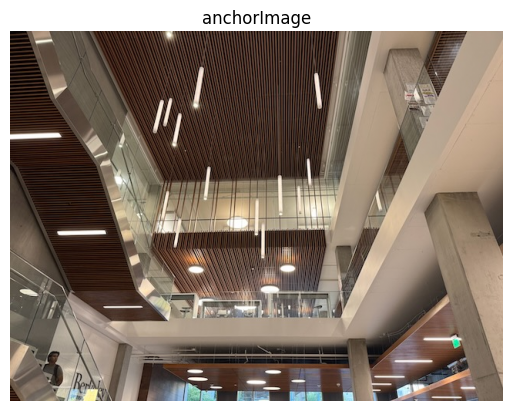

In [149]:
# Warp 2 images
# import images
# warp the right image to the left image
def create_homography(anchorImagePath, targetImagePath):
    # import correspondences
    anchorImage = load_image_as_float(anchorImagePath)
    targetImage = load_image_as_float(targetImagePath)

    # import correspondences
    try:
        anchorPoints, targetPoints = import_correspondences(anchorImagePath, targetImagePath, anchorImage, targetImage)
    except:
        targetPoints, anchorPoints = import_correspondences(targetImagePath, anchorImagePath, targetImage, anchorImage)

    show_image_with_points(anchorImage, anchorPoints, title='Anchor Points')
    show_image_with_points(targetImage, targetPoints, title='Target Points')
    
    # compute the homography matrix
    H = computeH(targetPoints, anchorPoints)

    # warp the image
    warped_im = warpImage(targetImage, H)
    return warped_im, anchorImage

warped_im, anchorImage = create_homography('IMG_2815.jpeg', 'IMG_2814 (1).jpeg')
show_image(warped_im, "warped_im")
# show original anchor image
show_image(anchorImage, "anchorImage")


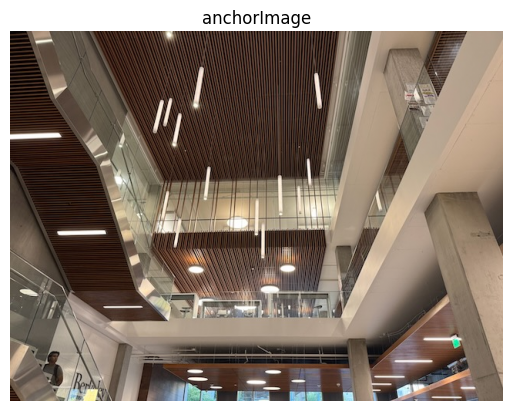

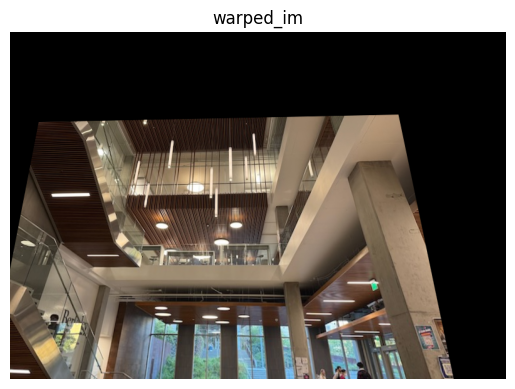

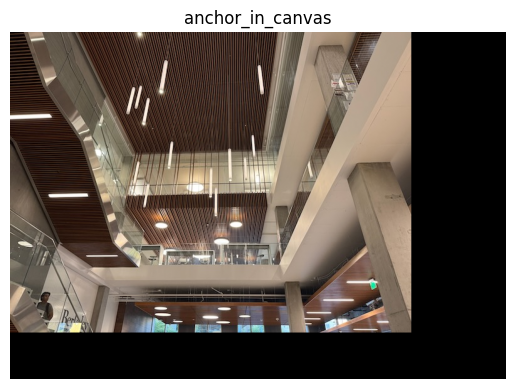

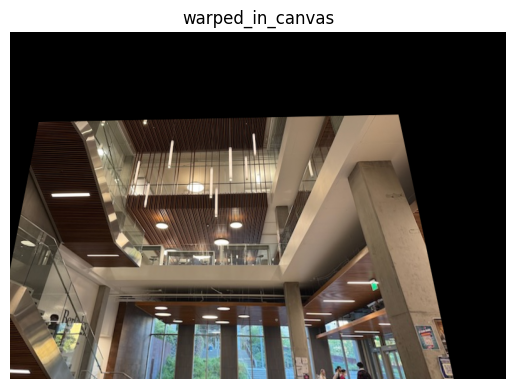

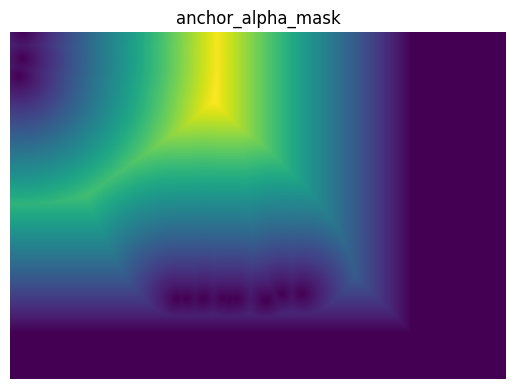

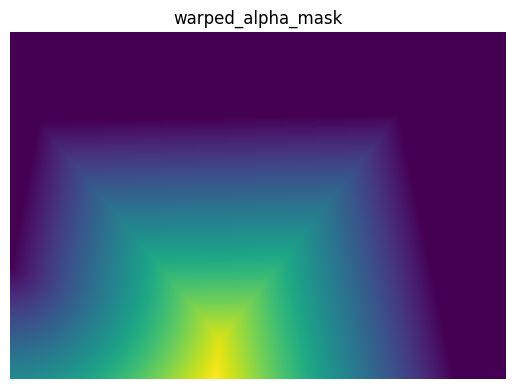

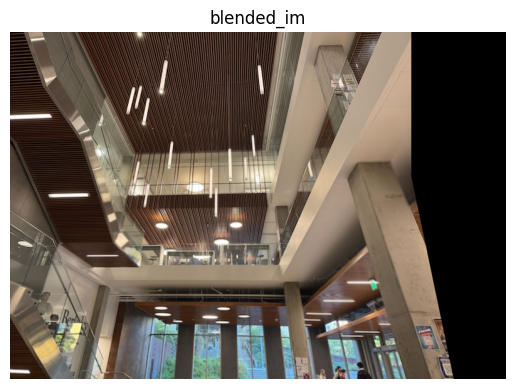

In [158]:
def dumb_blending(anchorImage, warpedImage):
    # create a canvas that is the size of both images added together
    joint_image = np.zeros((anchorImage.shape[0] + warpedImage.shape[0], anchorImage.shape[1] + warpedImage.shape[1], 3))
    print("joint_image shape: ", joint_image.shape)
    # weighted average
    joint_image[:anchorImage.shape[0], :anchorImage.shape[1]] = anchorImage
    joint_image[:warpedImage.shape[0], :warpedImage.shape[1]] = warpedImage + joint_image[:warpedImage.shape[0], :warpedImage.shape[1]]
    return joint_image

def put_image_in_canvas(image, canvas):
    # put the image in the canvas
    canvas[:image.shape[0], :image.shape[1]] = image
    return canvas

def compute_distance_transform(image_mask):
    # Invert the mask (so non-zero regions are treated as foreground)
    # inverted_mask = 1 - image_mask
    # Compute the Euclidean distance transform
    dist_transform = distance_transform_edt(image_mask)
    # Normalize to the range [0, 1]
    dist_transform = dist_transform / np.max(dist_transform)
    return dist_transform


def generate_alpha_mask(image):
    # Convert image to 8-bit unsigned integer forma
    image = (image * 255).astype(np.uint8)
    threshold = 0
    mask = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) > threshold
    dist_transform = compute_distance_transform(mask)
    return dist_transform

def generate_blend_canvas(anchorImage, warpedImage):
    # generate canvas
    # joint_image = np.zeros((anchorImage.shape[0] + warpedImage.shape[0], anchorImage.shape[1] + warpedImage.shape[1], 3))

    # Calculate the maximum dimensions needed to contain both images
    max_height = max(anchorImage.shape[0], warpedImage.shape[0])
    max_width = max(anchorImage.shape[1], warpedImage.shape[1])
    
    # Create a canvas with these maximum dimensions
    canvas = np.zeros((max_height, max_width, 3))
    
    return canvas

def blend_images(anchorImage, warpedImage, anchorImagePath="anchorImage", warpedImagePath="warpedImage"):
    # generate canvas
    anchor_blank_canvas = generate_blend_canvas(anchorImage, warpedImage)
    warped_blank_canvas = generate_blend_canvas(warpedImage, anchorImage)

    # put the images in the canvas
    anchor_in_canvas = put_image_in_canvas(anchorImage, anchor_blank_canvas)
    warped_in_canvas = put_image_in_canvas(warpedImage, warped_blank_canvas)
    show_image(anchor_in_canvas, "anchor_in_canvas")
    show_image(warped_in_canvas, "warped_in_canvas")
    export_image(anchor_in_canvas, f'/{anchorImagePath.split(".")[0]}_{warpedImagePath.split(".")[0]}_anchor_in_canvas.jpg')
    export_image(warped_in_canvas, f'/{warpedImagePath.split(".")[0]}_{anchorImagePath.split(".")[0]}_warped_in_canvas.jpg')

    # generate alpha mask
    anchor_alpha_mask = generate_alpha_mask(anchor_in_canvas)
    warped_alpha_mask = generate_alpha_mask(warped_in_canvas)
    show_image(anchor_alpha_mask, "anchor_alpha_mask")
    show_image(warped_alpha_mask, "warped_alpha_mask")
    export_image(anchor_alpha_mask, f'/{anchorImagePath.split(".")[0]}_{warpedImagePath.split(".")[0]}_anchor_alpha_mask.jpg')
    export_image(warped_alpha_mask, f'/{warpedImagePath.split(".")[0]}_{anchorImagePath.split(".")[0]}_warped_alpha_mask.jpg')

    # blend the images together
    # weighted average for each channel
    total_alpha_mask = anchor_alpha_mask + warped_alpha_mask
    non_zero_mask = total_alpha_mask > 0
    # separate for each channel
    for i in range(3):
        anchor_blank_canvas[:, :, i] = ((anchor_in_canvas[:, :, i] * anchor_alpha_mask) + (warped_in_canvas[:, :, i] * warped_alpha_mask))
        anchor_blank_canvas[:, :, i] = np.divide(anchor_blank_canvas[:, :, i], total_alpha_mask, where=non_zero_mask)

    
    return anchor_blank_canvas
show_image(anchorImage, "anchorImage")
show_image(warped_im, "warped_im")

blended_im = blend_images(anchorImage, warped_im)
export_image(blended_im, '_blended.jpg')
show_image(blended_im, "blended_im")

len of im1Points:  13


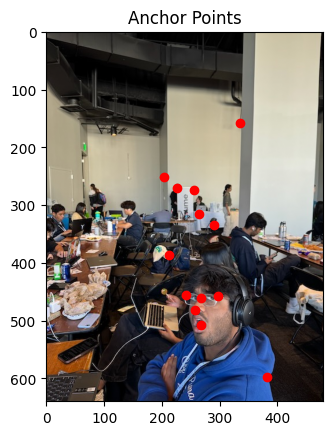

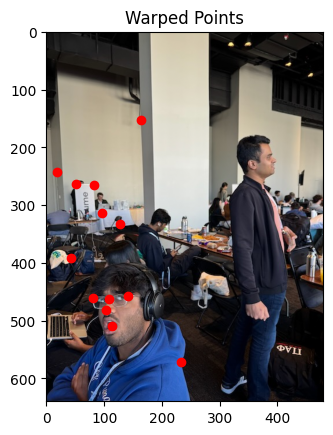

h:  [ 6.08022972e-01 -6.27393776e-02  2.01987406e+02 -2.22553078e-01
  8.55565131e-01  4.30090081e+01 -7.43664980e-04 -4.19742065e-05]
h shape:  (8,)
corners:  [[  0   0]
 [  0 639]
 [479   0]
 [479 639]]


/var/folders/zq/lptg8bhj1_7csl86sd1517pc0000gn/T/ipykernel_28219/2846865240.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  h = np.linalg.lstsq(A, B)[0]


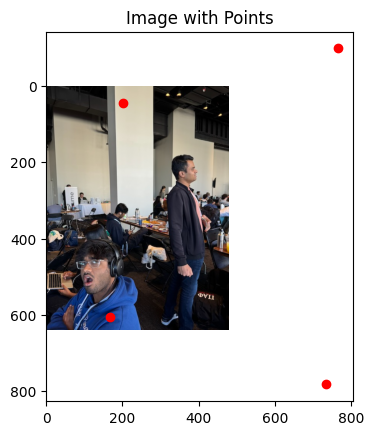

warped_height:  881
warped_width:  599


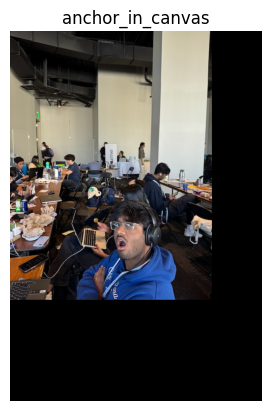

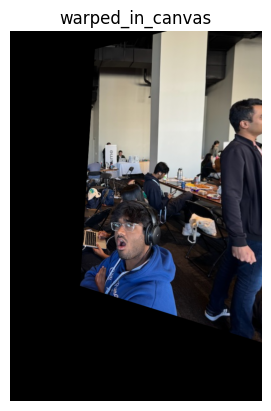

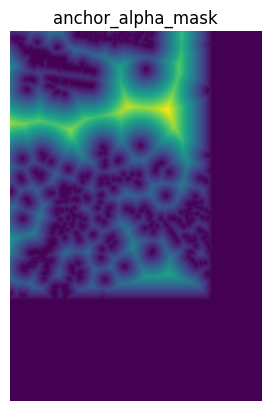

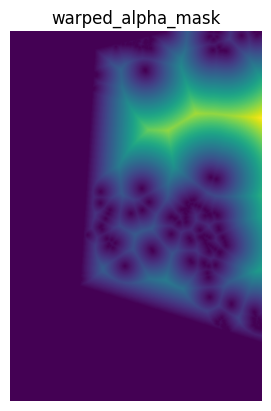

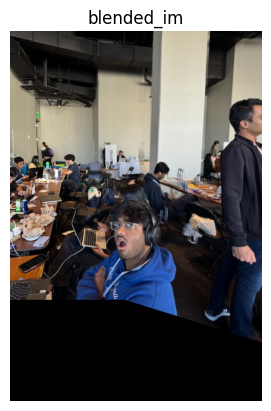

In [155]:
def full_homography(anchorImagePath, targetImagePath):
    warped_im, anchorImage = create_homography(anchorImagePath, targetImagePath)
    blended_im = blend_images(anchorImage, warped_im, anchorImagePath, targetImagePath)
    export_image(blended_im, f'/{anchorImagePath.split(".")[0]}_{targetImagePath.split(".")[0]}_blended.jpg')
    return blended_im

blended_im = full_homography('IMG_2827.jpeg', 'IMG_2828.jpeg')
show_image(blended_im, "blended_im")

len of im1Points:  10


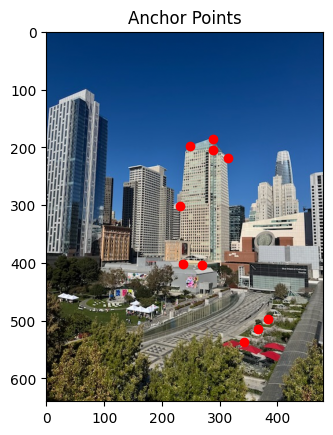

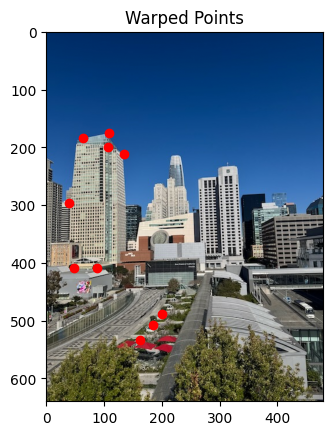

h:  [ 5.71026120e-01  2.05466532e-04  1.98194290e+02 -2.89630516e-01
  8.48025678e-01  4.87489295e+01 -8.86259130e-04 -1.80732875e-05]
h shape:  (8,)
corners:  [[  0   0]
 [  0 639]
 [479   0]
 [479 639]]


/var/folders/zq/lptg8bhj1_7csl86sd1517pc0000gn/T/ipykernel_28219/2846865240.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  h = np.linalg.lstsq(A, B)[0]


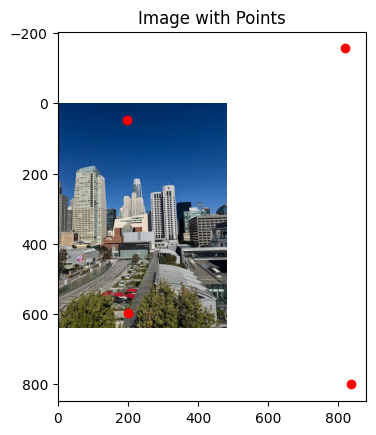

warped_height:  957
warped_width:  638


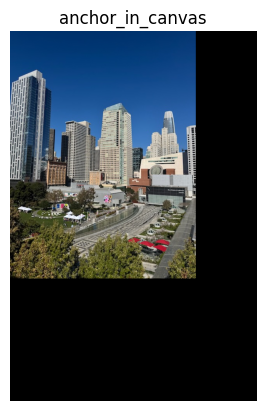

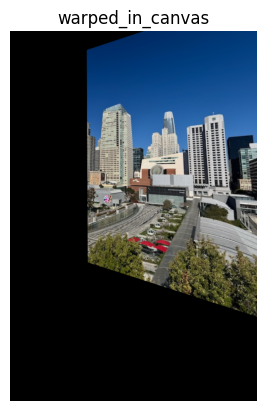

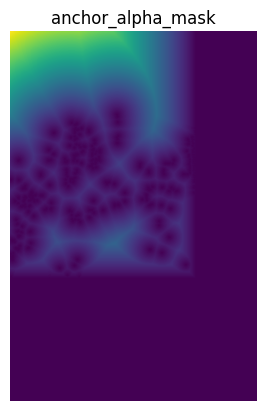

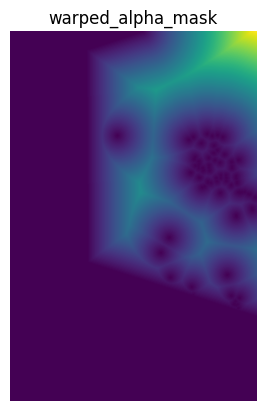

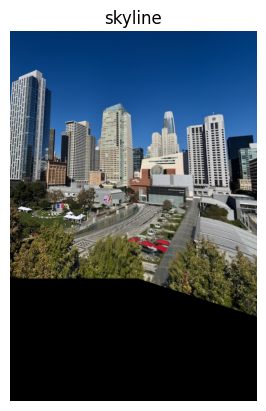

In [156]:
skyline = full_homography('IMG_2830.jpeg', 'IMG_2831.jpeg')
show_image(skyline, "skyline")